In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from google.colab import files
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [2]:
# Download latest version
path = kagglehub.dataset_download("suruchiarora/yahoo-finance-dataset-2018-2023")

print("Path to dataset files:", path)

100%|██████████| 77.5k/77.5k [00:00<00:00, 44.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1


In [3]:
print(os.listdir(path))  # List files in the dataset folder

['yahoo_data.xlsx']


In [43]:
df=pd.read_excel(path+'/yahoo_data.xlsx')



In [41]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [44]:
df["Date"] = pd.to_datetime(df["Date"]).sort_values(ascending=True)
# Trier les données du plus ancien au plus récent
df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)

In [45]:
dataset = df[['Date', 'Open']]
len(dataset)

1258

In [46]:

dataset=dataset.set_index('Date')
dataset

,Open
Date,
2018-05-01,24117.29
2018-05-02,24097.63
2018-05-03,23836.23
2018-05-04,23865.22
2018-05-07,24317.66
...,...
2023-04-24,33805.04
2023-04-25,33828.34
2023-04-26,33596.34


In [47]:
dataset.isnull().sum()

,0
Open,0


In [48]:
# Compter les valeurs négatives
negative_values = df[df['Open'] < 0]
print(len(negative_values))

0


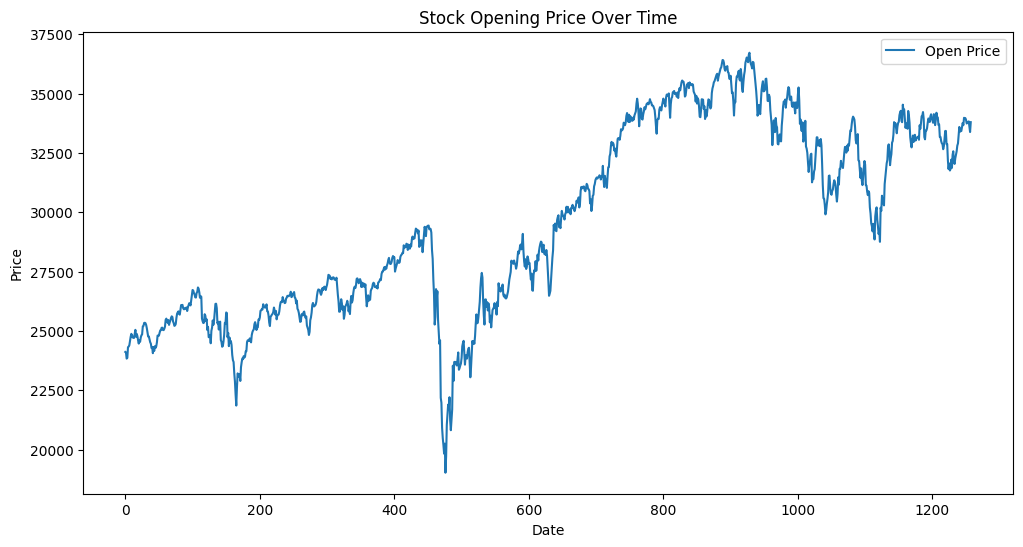

In [49]:
# Plot stock opening price over time
plt.figure(figsize=(12, 6))
plt.plot(df["Open"], label="Open Price")
plt.title("Stock Opening Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [50]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset[['Open']].values)

In [51]:
dataset_scaled

array([[0.28760376],
       [0.28649267],
       [0.2717195 ],
       ...,
       [0.82331764],
       [0.81118488],
       [0.83468236]])

In [52]:
# Création des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [53]:
# Augmentation de données : ajout de bruit
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [54]:
# Création des séquences avec données augmentées
seq_length = 60
X, y = create_sequences(dataset_scaled, seq_length)
X_noisy, y_noisy = create_sequences(add_noise(dataset_scaled), seq_length)

In [55]:
# Reshape des données pour LSTM [samples, time steps, features]
X = np.concatenate((X, X_noisy))
y = np.concatenate((y, y_noisy))
# Reshape des données pour LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [56]:
# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [57]:
seq_length = 60
train_size = int(len(X) * 0.8)
lr=0.001
unit=150
dropout=0.3
n_epochs = 150
batch_size = 64

In [58]:
# 2. Construction du modèle LSTM

regressor_lstm = Sequential()

# Première couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor_lstm.add(Dropout(dropout))

# Deuxième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True))
regressor_lstm.add(Dropout(dropout))

# Troisième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit))
regressor_lstm.add(Dropout(dropout))

# Couche de sortie
regressor_lstm.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
# Optimiseur avec un taux d'apprentissage plus faible
optimizer = Adam(learning_rate=lr)
regressor_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

In [60]:
# Entraînement du modèle
regressor_lstm.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 482ms/step - loss: 0.0580
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - loss: 0.0063
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 470ms/step - loss: 0.0049
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 474ms/step - loss: 0.0050
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - loss: 0.0049
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 480ms/step - loss: 0.0045
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - loss: 0.0042
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - loss: 0.0039
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - loss: 0.0038
Epoch 10/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - loss: 0.0035
Epoch 11/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 469ms/step - loss: 0.0033
Epoch 12/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - loss: 0.0032
Epoch 13/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - loss: 0.0029
Epoch 14/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - loss: 0.0031
Epoch 15/150
30/30 ━━━━━━━━━━

In [61]:
# Sauvegarder le modèle
filename = 'regressor_lstm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(regressor_lstm, file)

from google.colab import files

# Télécharger le fichier
files.download(filename)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.upload()

In [ ]:
# Load the LSTM model
with open('regressor_lstm_model.pkl', 'rb') as file:
    regressor_lstm = pickle.load(file)

In [63]:
# 4. Prédiction
y_predicted = regressor_lstm.predict(X_test)
y_predicted = scaler.inverse_transform(y_predicted)  # Transformation inverse pour obtenir les valeurs réelles
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))  # Transformation inverse pour les valeurs réelles


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


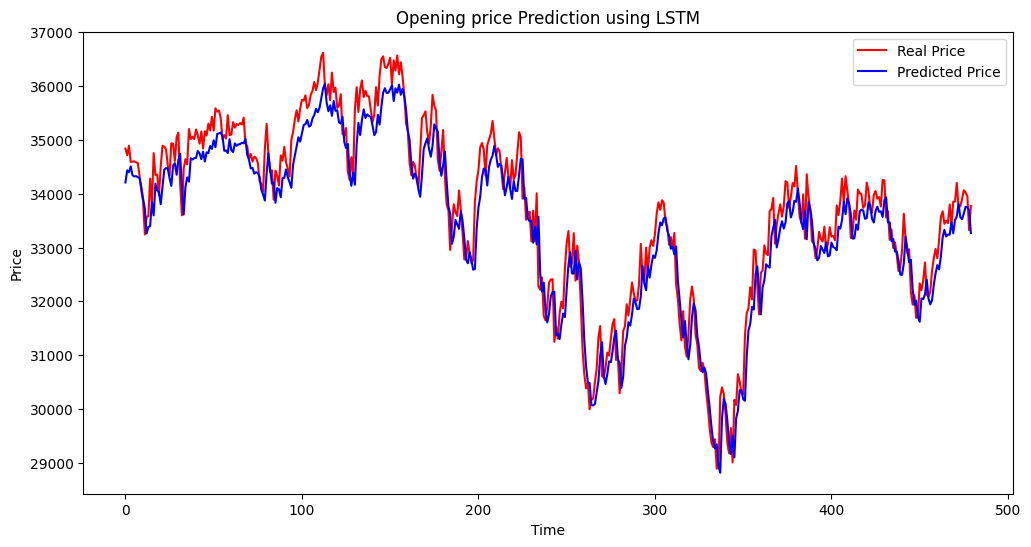

In [68]:
# 5. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_real, color='red', label='Real Price')
plt.plot(y_predicted, color='blue', label='Predicted Price')
plt.title('Opening price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

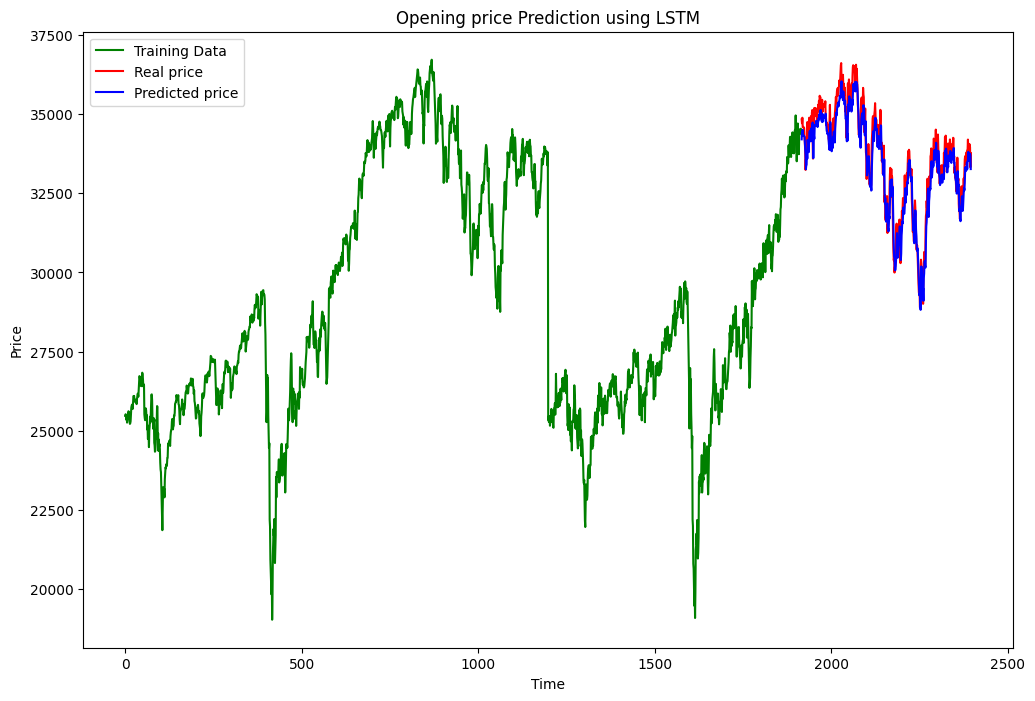

In [65]:
# 6. Visualisation de l'entraînement, des prédictions et des tests
train_range = range(len(y_train))
test_range = range(len(y_train), len(y_train) + len(y_real))
pred_range = range(len(y_train), len(y_train) + len(y_predicted))

plt.figure(figsize=(12, 8))
plt.plot(train_range, scaler.inverse_transform(y_train.reshape(-1, 1)), color='green', label='Training Data')
plt.plot(test_range, y_real, color='red', label='Real price')
plt.plot(pred_range, y_predicted, color='blue', label='Predicted price')
plt.title('Opening price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [69]:
# 7. Évaluation du modèle
print("Evaluation du modèle:")
mse_lstm = mean_squared_error(y_real, y_predicted)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_real, y_predicted)
r2_lstm = r2_score(y_real, y_predicted)

print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"R² Score: {r2_lstm}")

Evaluation du modèle:
Mean Squared Error (MSE): 226454.73978071858
Mean Absolute Error (MAE): 388.8524873832417
R² Score: 0.9168490091999741


In [72]:
import datetime

# Function to predict the stock price for a given future date
def predict_future_price(date_input, model, dataset, scaler, seq_length=60):
    # Convert user input to datetime
    try:
        future_date = datetime.datetime.strptime(date_input, "%Y-%m-%d")
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return

    # Get the last 'seq_length' days of data
    last_days = dataset[-seq_length:].values
    last_days_scaled = scaler.transform(last_days)

    # Reshape to match model input
    X_future = last_days_scaled.reshape(1, seq_length, 1)

    # Predict the stock price
    predicted_price = model.predict(X_future)

    # Reverse normalization to get the actual price
    predicted_price_actual = scaler.inverse_transform(predicted_price.reshape(-1, 1))[0][0]

    print(f"Predicted stock price for {date_input}: {predicted_price_actual:.2f}")

# Ask user for a future date
user_date = input("Enter a future date (YYYY-MM-DD) to predict stock price: ")

# Make prediction
predict_future_price(user_date, regressor_lstm, dataset[['Open']], scaler)


Enter a future date (YYYY-MM-DD) to predict stock price: 2023-04-21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted stock price for 2023-04-21: 33493.65


# FIN